**Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 19 Nov (Testing Multivariate)**



1. Test on all Monday 24 hours data for Connector SB L_2 & Juniper WB L_1

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
#check
print (dataset.iloc[49]['State-EB-L_1'])
print (dataset.iloc[3359]['State-EB-L_1'])

-10.0
7.0


[25. 30. 54. ... 29. 25. 18.]
[[14. 25.]
 [11. 30.]
 [12. 54.]
 ...
 [10. 29.]
 [ 2. 25.]
 [ 4. 18.]]


(-15.65, 150)

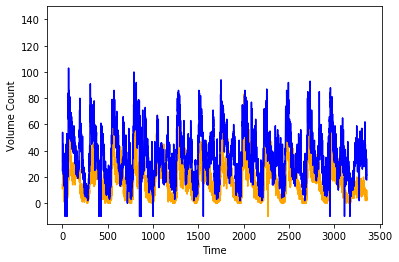

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_1 series 
series = dataset['Connector-SB-L_2'].values
series_output = dataset['Connector-SB-L_2'].values
print (series_output)
series_inputs = dataset[['Luckie-EB-L_2','Connector-SB-L_2']].values
print (series_inputs)
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
#plot_series(time_num, series)
# plot_series(time_num, series_inputs[:,0])
# plot_series(time_num, series_inputs[:,1])

plt.plot(time_num, series_inputs[:,0], color='orange')
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

(-14.65, 150)

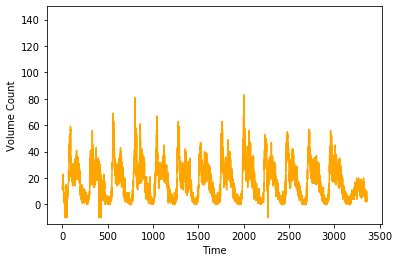

In [5]:
plt.plot(time_num, series_inputs[:,0], color='orange')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

(-15.65, 150)

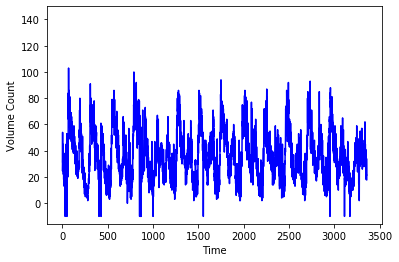

In [6]:
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [7]:
num_days = 11
split_time = num_days*240
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]

time_train = time[:split_time]
x_train = series_inputs[:split_time]
time_valid = time[split_time:]
x_valid = series_inputs[split_time:]

window_size = 100
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [ ]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = series.astype(np.float64)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
    dataset = dataset.batch(batch_size).prefetch(1)
#     print (dataset)
#     for window in dataset:
#         print (window[0].shape)
    return dataset
# for window in dataset:
#     print (window)
    #dataset = dataset.map(lambda window: (window[:-1], window[-1][1]))
#dataset = dataset.map(lambda window: (window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
    #print (window.numpy()[1])
    #dataset = dataset.batch(batch_size).prefetch(1)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
#     print (window[1].numpy())
    #return dataset
# dataset = tf.data.Dataset.from_tensor_slices(series_output)
# # print (dataset)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

# dataset = dataset.map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)

# print (dataset)
# dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
  #return dataset


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(series_inputs)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
dataset = dataset.batch(batch_size).prefetch(3)
print (dataset)
for window in dataset:
    print (window[0].shape)

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#y = tf.cast(y, tf.float32)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print (dataset)
#dataset = tf.cast(dataset, tf.float64)

model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=None),
    #tf.keras.layers.Lambda(lambda x:tf.cast(x, tf.float64)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])


In [ ]:
for window in dataset:
    print (window[0].numpy())
    print (window[1].numpy())

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('connector_sb_l2.h5')

In [8]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('connector_sb_l2.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  8960      
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  33600     
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  38720     
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  28928     
_________________________________________________________________
dense (Dense)                multiple                  65        
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 110,273
Trainable params: 110,273
Non-trainable params: 0
__________________________________________________

(-15.15, 120)

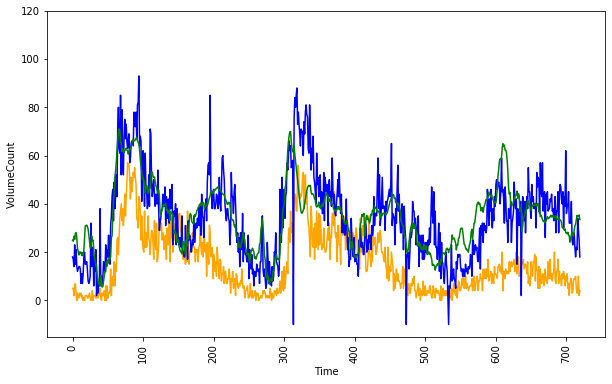

In [9]:

forecast = []
results = []
for time in range(len(series_inputs) - window_size):
    forecast.append(new_model.predict(series_inputs[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
time_valid = [i for i in range(len(time_valid))]
plt.plot(time_valid, x_valid[:,0], color='orange')
plt.plot(time_valid, x_valid[:,1], color='blue')
plt.plot(time_valid, results, color='green')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()

8.887518

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], results).numpy()

19.92328

In [12]:
mae = tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid[:,1] - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 8.887518
mean squared error: 137.35512
root mean squared error: 11.719859973474579
forecast_bias: -202.8039846420288
standard dev of errors: 11.716474825372101


## Forecasts for Typical Day Slice

In [13]:
typical_actuals = x_valid[:,1][:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 8.530756
mean squared error: 134.31065
root mean squared error: 11.589247330457809
forecast_bias: 373.26954650878906
standard dev of errors: 11.563127700512519


(-15.15, 120)

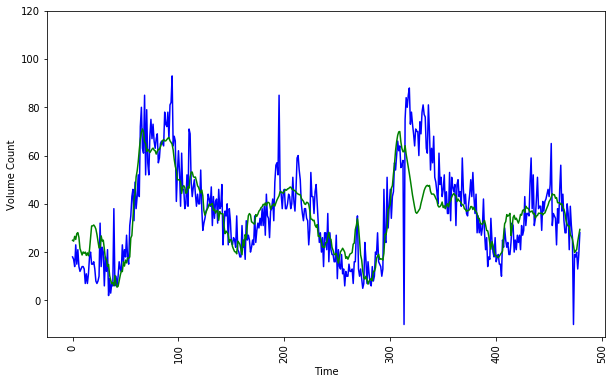

In [14]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## Forecasts for Atypical Day Slice

In [15]:
atypical_actuals = x_valid[:,1][-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 9.601042
mean squared error: 143.44406
root mean squared error: 11.976813486036129
forecast_bias: -576.0735311508179
standard dev of errors: 11.73382232641983


(-13.745847702026367, 120)

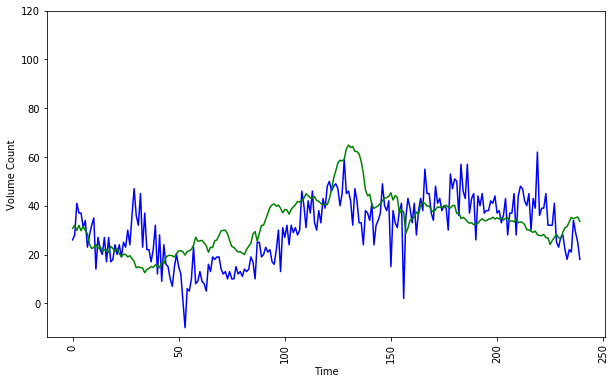

In [16]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
forecast = []
results = []

slice_val_time = 230
sliced_val_series = x_valid[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 30
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
sliced_val_times = time_valid[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

#print (sliced_val_series)
# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series[:,1])
#print (sliced_val_series[:,1].shape)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,0], sliced_val_series[:,1]).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
actuals = sliced_val_actual[:,1][-30:]
predictions = sliced_val_series[:,1][-30:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals - predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Different Time Slice

In [ ]:
forecast = []
results = []
mae_array = []
rmse_array = []
std_array = []

for slice_val_time in range(100,351,10):

    #slice_val_time = 630
    sliced_val_series = x_valid[:slice_val_time]
    #print (sliced_val_series)
    #print (x_valid)

    number_missing_units = 120
    # print (sliced_val_series[-1][0])
    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    for t in range(number_missing_units):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
       # print (t)
        #if t == 0: 
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        #print (forecast)
        #else:
           # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
        p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
        #print (p)
        sliced_val_series = np.append(sliced_val_series, p, axis=0)
        #print (sliced_val_series)


    sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
    sliced_val_times = time_valid[:slice_val_time+number_missing_units]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    actuals = sliced_val_actual[:,1][-number_missing_units:]
    predictions = sliced_val_series[:,1][-number_missing_units:]
    
    mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
    print ("mean absolute error: "+ str(mae))
    mae_array.append(mae)
    mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
    print ("root mean squared error: "+ str(rmse))
    rmse_array.append(rmse)
    array_of_errors = (actuals - predictions)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    std_array.append(std_dev_errors)



In [ ]:
print (mae_array)
print (rmse_array)
print (std_array)

## Model Performance on 18th March for Simulation Experiment

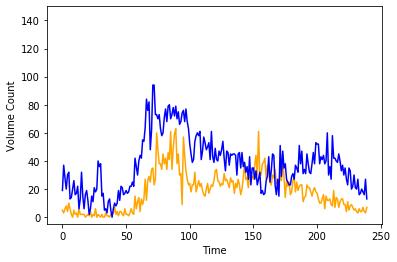

In [10]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)
#print (dataset_original)
## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
#print (dataset_original)
dataset_original = dataset_orginal[:-240]
#print (dataset_original)
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]

#extract State-EB-L_1 series for 18th March
#series_18march = dataset_original['State-EB-L_1'].values
series_18march = dataset_original[['Luckie-EB-L_2','Connector-SB-L_2']].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march[:,0], color='orange')
plt.plot(time_num_18march, series_18march[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

(-4.7, 150)

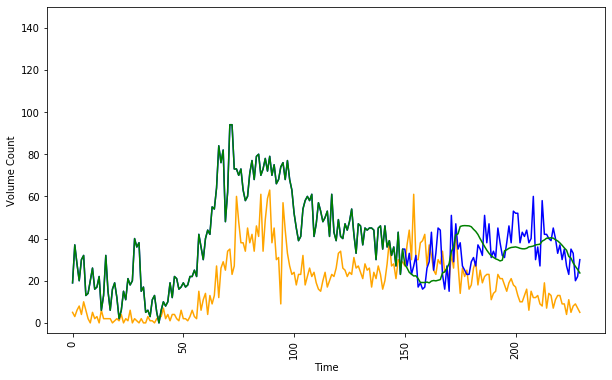

In [11]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 80
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[series_18march[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+number_missing_units] 
sliced_val_times = time_18march[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

In [12]:
actuals_18Mar = sliced_val_actual[:,1][-80:]
print (actuals_18Mar)
predictions_18Mar = sliced_val_series[:,1][-80:]
print (predictions_18Mar)

mae = tf.keras.metrics.mean_absolute_error(actuals_18Mar, predictions_18Mar).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_18Mar, predictions_18Mar).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_18Mar, predictions_18Mar).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_18Mar - predictions_18Mar)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[35. 27. 33. 23. 27. 32. 17. 19. 16. 17. 26. 29. 43. 25. 33. 45. 44. 23.
 16. 27. 15. 51. 29. 47. 35. 38. 27. 25. 23. 23. 29. 31. 27. 37. 35. 32.
 51. 38. 47. 31. 34. 31. 45. 38. 32. 31. 38. 46. 38. 53. 52. 52. 38. 43.
 41. 44. 38. 40. 60. 30. 36. 27. 58. 42. 42. 40. 39. 45. 40. 33. 37. 30.
 35. 27. 23. 35. 33. 20. 22. 30.]
[27.63430786 26.04713058 23.95854568 23.09657097 22.24604607 22.34170532
 21.0164566  19.18303299 19.17233849 19.13986588 19.36108398 18.98535728
 19.83746719 20.09632874 19.93631363 20.24627304 20.51433563 23.66123009
 24.28168297 25.86117172 28.20978165 33.87312698 35.9838829  41.71696091
 42.22426224 45.73584366 46.0548439  46.14564133 46.0684166  46.0187149
 45.60102844 44.40242767 43.38949203 41.94158936 39.90738297 38.01066971
 36.21088409 34.47732162 33.02609634 31.76231956 31.0868988  30.38699722
 29.97409058 29.38577461 29.7509613  34.21384048 34.67065048 35.38365173
 35.75860214 35.90433502 36.04193878 35.76990891 35.37824249 35.15190506
 35.11823273 35.37

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_connector_sb_l2_multivariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_connector_sb_l2_multivariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

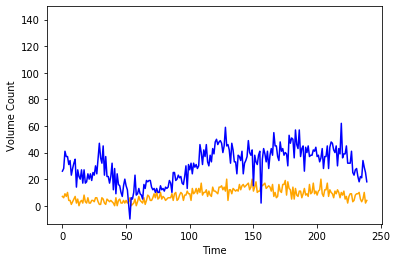

In [22]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 27th May
#series_18march = dataset_original['State-EB-L_1'].values
series_27may = dataset_original[['Luckie-EB-L_2','Connector-SB-L_2']].values
time_27may = dataset_original['date_time'].values

time_num_27may = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_27may, series_27may[:,0], color='orange')
plt.plot(time_num_27may, series_27may[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

#print (series_27may)

(-13.853766632080077, 150)

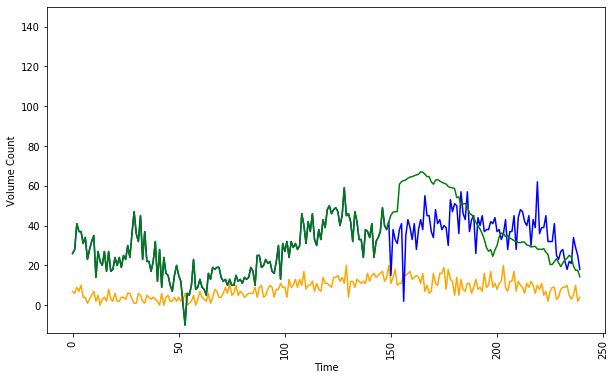

In [29]:
##apply model to the 27 May data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_27may[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 90
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))

    p = [[series_27may[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    #p = [sliced_val_series,p]
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)
    #forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
# print (sliced_val_series)
# print (sliced_val_actual)
sliced_val_actual = series_27may[:slice_val_time+number_missing_units] 
sliced_val_times = time_27may[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

In [31]:
actuals_27May = sliced_val_actual[:,1][-90:]
print (actuals_27May)
predictions_27May = sliced_val_series[:,1][-90:]
print (predictions_27May)

mae = tf.keras.metrics.mean_absolute_error(actuals_27May, predictions_27May).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_27May, predictions_27May).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_27May, predictions_27May).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_27May - predictions_27May)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[15. 38. 33. 31. 38. 41.  2. 35. 43. 39. 33. 41. 28. 38. 43. 38. 55. 45.
 45. 37. 34. 48. 41. 43. 38. 40. 39. 30. 53. 47. 51. 50. 36. 57. 46. 43.
 57. 37. 43. 45. 26. 44. 40. 45. 37. 38. 38. 42. 41. 44. 37. 38. 33. 36.
 43. 28. 37. 37. 45. 28. 44. 48. 47. 42. 40. 45. 30. 43. 39. 62. 36. 39.
 39. 45. 32. 32. 32. 41. 25. 23. 27. 28. 22. 18. 22. 21. 34. 29. 25. 18.]
[45.28815842 46.77243805 46.9563179  47.08774567 60.74851608 62.12379837
 62.58951569 62.90914917 63.79225922 64.43540192 64.58578491 65.07310486
 65.42517853 65.80908966 67.07533264 66.79779053 65.8727417  64.59680176
 64.62050629 61.99404144 60.79546738 62.8409729  63.12667084 62.39131546
 61.74538803 61.29571915 60.8380127  59.64704895 59.14427567 59.00519943
 58.58480453 54.07213593 54.42206955 50.3250885  50.88308334 51.05919266
 49.88497543 45.9945488  45.53462219 43.79112244 41.68340683 39.85488892
 38.23518372 35.91091537 33.05400085 28.97168159 27.12111855 27.87594223
 24.5682869  27.7455864  29.95112228 34.39722443 3

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_connector_sb_l2_multivariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_connector_sb_l2_multivariate_27may.csv")